In [ ]:
"""
Purpose: 

To Determine which of the branches are 
potential axon candidates

"""

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from os import sys
sys.path.append("/meshAfterParty/")

In [3]:
from importlib import reload

import neuron_utils as nru

import neuron

import neuron_visualizations as nviz

import time

import datajoint_utils as du

import numpy as np

import proofreading_utils as pru
import preprocessing_vp2 as pre

INFO - 2021-01-12 18:31:56,735 - settings - Setting database.host to at-database.ad.bcm.edu
INFO - 2021-01-12 18:31:56,737 - settings - Setting database.user to celiib
INFO - 2021-01-12 18:31:56,738 - settings - Setting database.password to newceliipass
INFO - 2021-01-12 18:31:56,743 - settings - Setting stores to {'minnie65': {'protocol': 'file', 'location': '/mnt/dj-stor01/platinum/minnie65', 'stage': '/mnt/dj-stor01/platinum/minnie65'}, 'meshes': {'protocol': 'file', 'location': '/mnt/dj-stor01/platinum/minnie65/02/meshes', 'stage': '/mnt/dj-stor01/platinum/minnie65/02/meshes'}, 'decimated_meshes': {'protocol': 'file', 'location': '/mnt/dj-stor01/platinum/minnie65/02/decimated_meshes', 'stage': '/mnt/dj-stor01/platinum/minnie65/02/decimated_meshes'}, 'skeletons': {'protocol': 'file', 'location': '/mnt/dj-stor01/platinum/minnie65/02/skeletons'}}
INFO - 2021-01-12 18:31:56,745 - settings - Setting enable_python_native_blobs to True
INFO - 2021-01-12 18:31:56,758 - connection - Connect

Connecting celiib@at-database.ad.bcm.edu:3306


INFO - 2021-01-12 18:31:57,064 - settings - Setting enable_python_native_blobs to True


In [ ]:
current_neuron_mesh.vertex_adjacency_graph

In [ ]:
import networkx as nx
list(nx.connected_components(current_neuron_mesh.vertex_adjacency_graph))

# Loading the Neuron Mesh

In [ ]:
import trimesh_utils as tu
current_neuron_mesh = tu.load_mesh_no_processing("/notebooks/test_neurons/meshafterparty_processed/12345_double_soma_meshafterparty_9_29.off")


In [ ]:
segment_id = 12345
description="classic_double_soma_12_29"
somas=None

In [ ]:
total_neuron_process_time = time.time()

print(f"\n--- Beginning preprocessing of {segment_id}---")
recovered_neuron = neuron.Neuron(
mesh = current_neuron_mesh,
somas = somas,
segment_id=segment_id,
description=description,
suppress_preprocessing_print=False,
suppress_output=False,
calculate_spines=True,
widths_to_calculate=["no_spine_median_mesh_center"]

        )

print(f"\n\n\n---- Total preprocessing time = {time.time() - total_neuron_process_time}")

# Doing the Actual Analysis of It

In [ ]:
recovered_neuron = neuron.Neuron(recovered_neuron)

In [ ]:
nviz.visualize_neuron(recovered_neuron,
                     visualize_type=["mesh","skeleton"],
                     limb_branch_dict="all")

# Save and Decompressing the neuron object

In [ ]:
recovered_neuron.save_compressed_neuron(output_folder="/notebooks/test_neurons/Segmentation_3/Multi_Soma/",
                                       export_mesh=True)

In [ ]:
curr_file = "/notebooks/test_neurons/Segmentation_3/Multi_Soma/12345_classic_double_soma_12_29"
neuron_obj = nru.decompress_neuron(curr_file,curr_file)

In [ ]:
neuron_obj = recovered_neuron

# Doing the Soma Splitting

In [ ]:
nviz.plot_soma_limb_concept_network(neuron_obj)

In [ ]:
limb_results = pru.multi_soma_split_suggestions(neuron_obj,
                                verbose=True,
                                )

In [ ]:
neuron_obj = neuron.Neuron(neuron_obj)
seperate_neuron_objects = pru.split_neuron(neuron_obj)

In [ ]:
len(seperate_neuron_objects)

# Checking that the limbs are all connected skeletons

In [ ]:
import skeleton_utils as sk

In [ ]:
for n_obj in seperate_neuron_objects:
    for c_limb in n_obj:
        print(sk.number_connected_components(c_limb.skeleton))

# Saving of the seperated pieces

In [ ]:
sep_neurons[0].save_compressed_neuron("./",
                                                 file_name="classic_double_neuron_1",
                                                 export_mesh=True)
sep_neurons[1].save_compressed_neuron("./",
                                                 file_name="classic_double_neuron_2",
                                                 export_mesh=True)

In [5]:
rec_neurons = [nru.decompress_neuron(f"classic_double_neuron_{k}",f"classic_double_neuron_{k}") for k in [1,2]]

for r in rec_neurons:
    nviz.visualize_neuron(r,
                     visualize_type=["mesh","skeleton"],
                     limb_branch_dict="all")

Decompressing Neuron in minimal output mode...please wait
Decompressing Neuron in minimal output mode...please wait

 Working on visualization type: mesh

 Working on visualization type: skeleton



 Working on visualization type: mesh

 Working on visualization type: skeleton


# Going to Now Classify Each of the Neurons

In [8]:
curr_neuron_obj = rec_neurons[0]
curr_neuron_obj

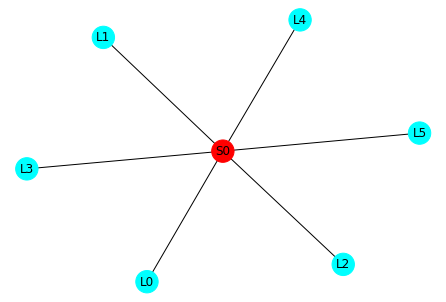

In [9]:
nviz.plot_soma_limb_concept_network(curr_neuron_obj)

In [10]:
soma_names = curr_neuron_obj.get_soma_node_names()
if len(soma_names)>1:
    raise Exception(f"More than 1 soma: {soma_names}")

soma_name = soma_names[0]

In [11]:
import neuron_statistics as nst

axon_soma_angle_threshold = 70
possible_axon_limbs = []

# Find the limb find the soma angle AND Filter away all limbs with a soma starting angle above threshold
limb_to_starting_angle = dict()
for curr_limb_idx,curr_limb in enumerate(curr_neuron_obj):
    curr_soma_angle = nst.soma_starting_angle(curr_neuron_obj,curr_limb_idx)
    limb_to_starting_angle[curr_limb_idx] = curr_soma_angle
    
    if curr_soma_angle > axon_soma_angle_threshold:
        possible_axon_limbs.append(curr_limb_idx)
    
    

limb_to_starting_angle,possible_axon_limbs

({0: 1.19, 1: 107.49, 2: 100.29, 3: 123.22, 4: 135.3, 5: 106.91},
 [1, 2, 3, 4, 5])

In [14]:
ret_col = nviz.visualize_neuron(curr_neuron_obj,
                     visualize_type=["mesh","skeleton"],
                     limb_branch_dict=dict(L2="all"),
                     return_color_dict=True)


 Working on visualization type: mesh

 Working on visualization type: skeleton


No limb name was given so using L2 because was the limb in the first key


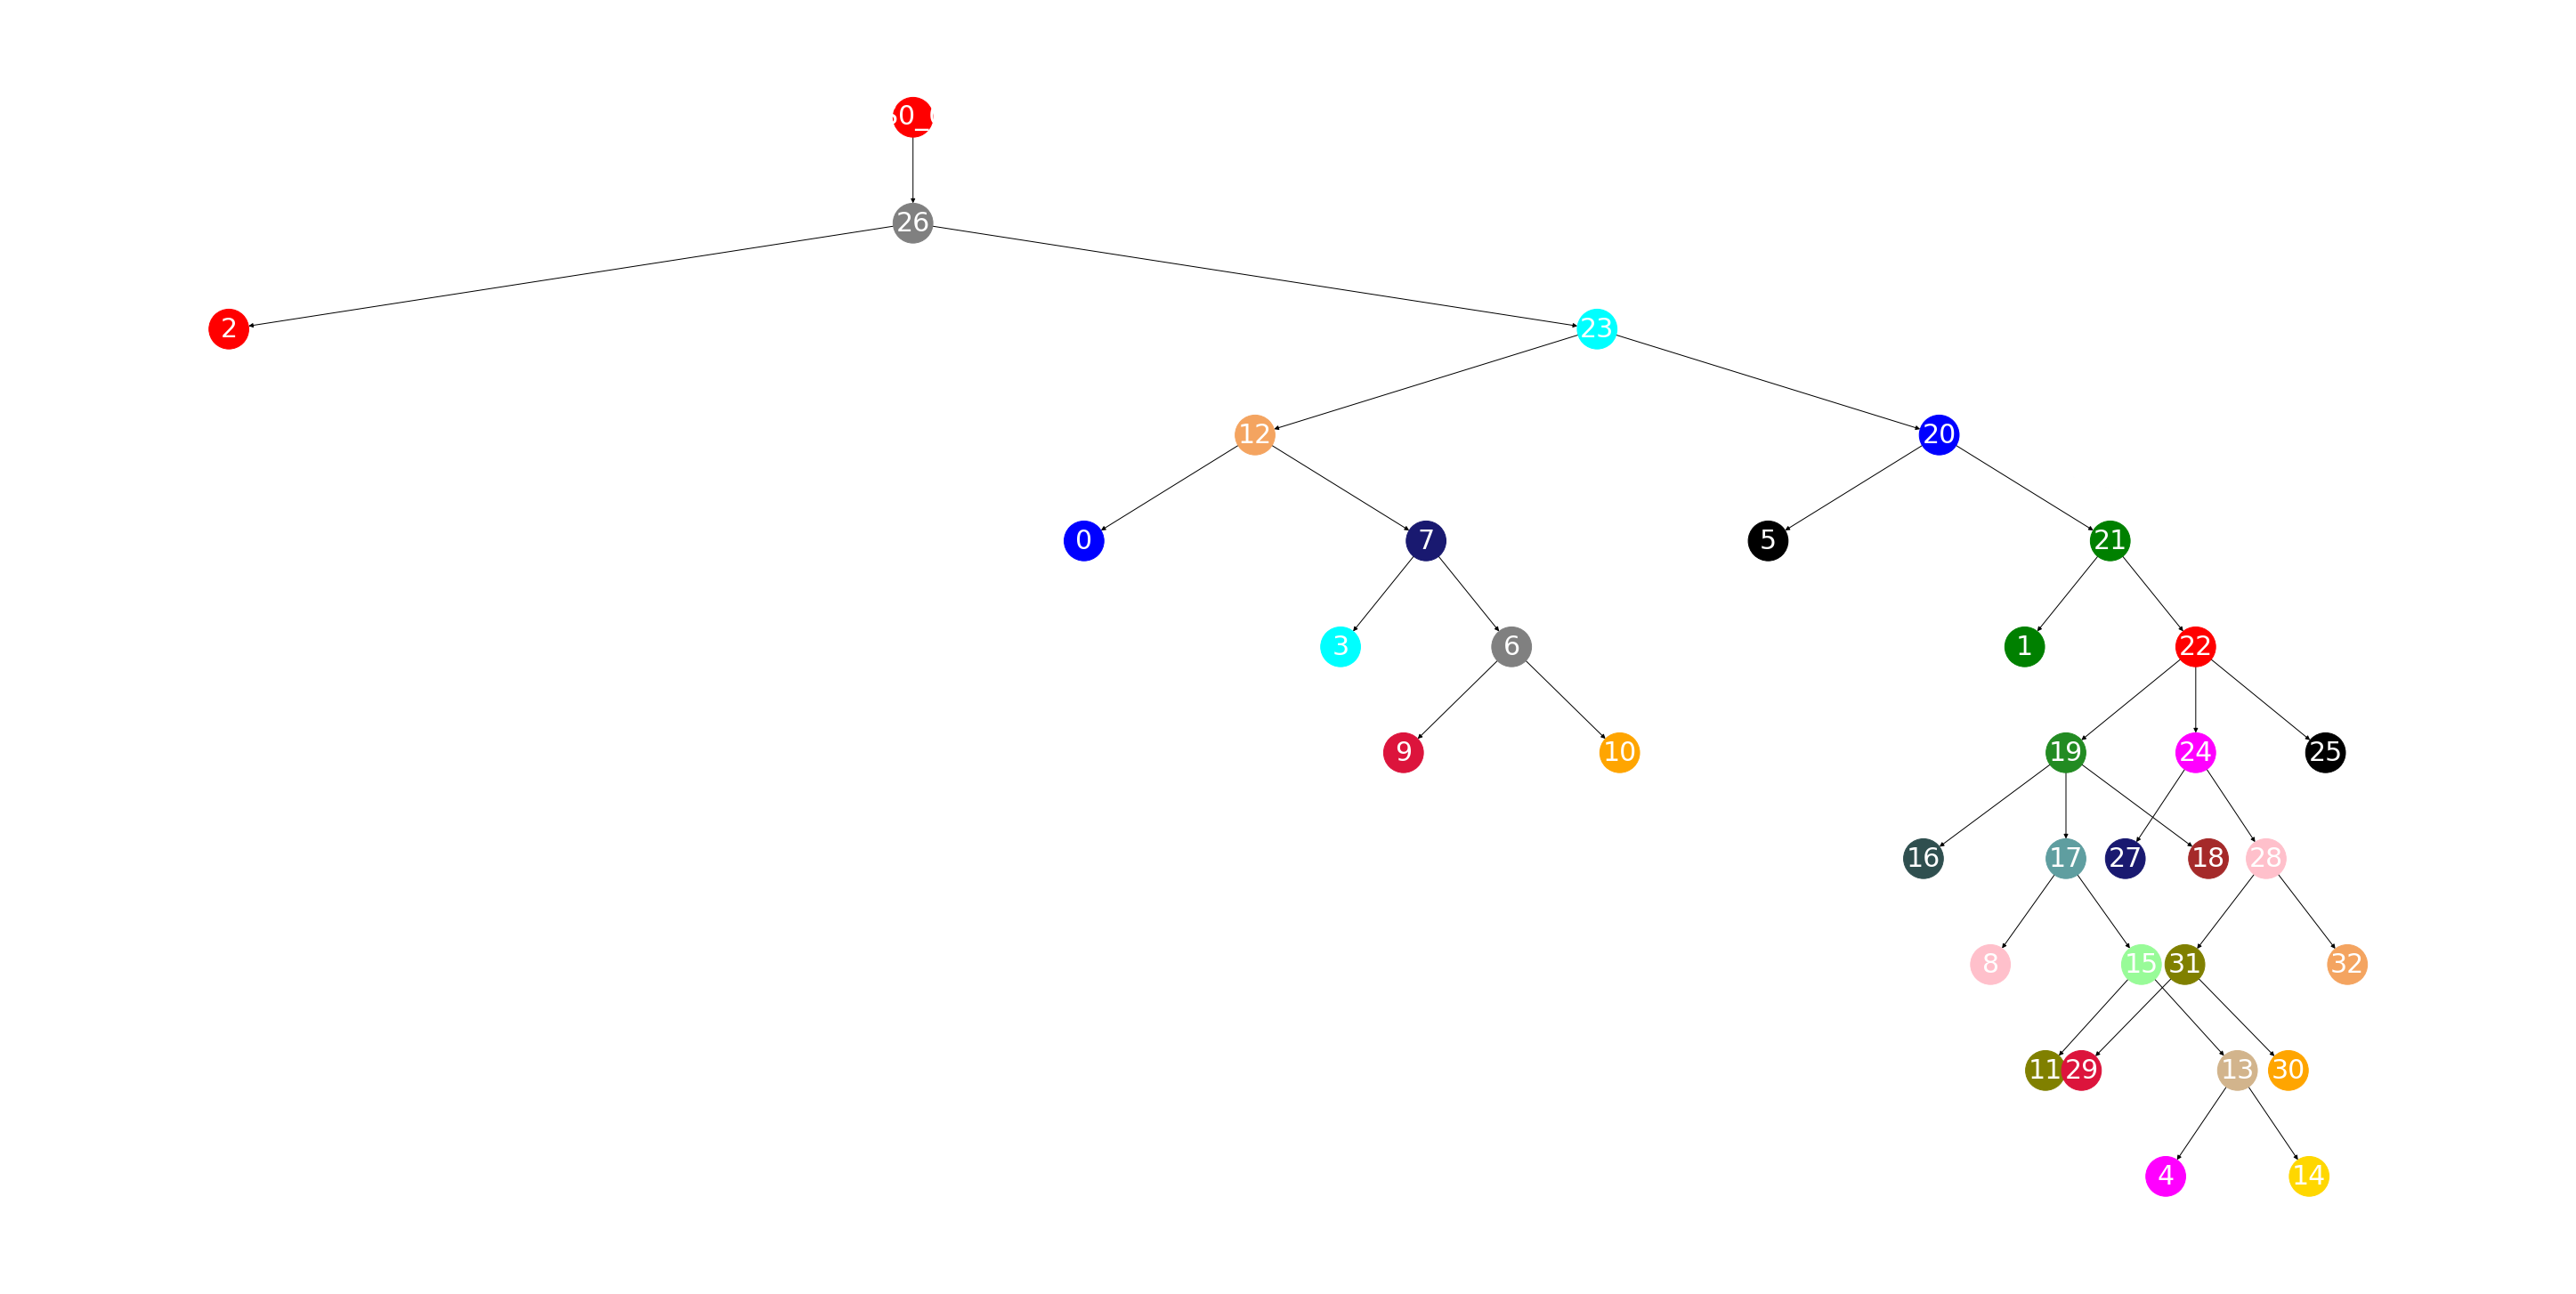

In [15]:
nviz.plot_limb_concept_network_2D(curr_neuron_obj,
                                 node_colors=ret_col)

In [ ]:
ex_branch = curr_neuron_obj[2][2]
ex_branch

In [ ]:
ex_branch.spines

In [ ]:
nviz.plot_objects(ex_branch.mesh,
                 meshes=ex_branch.spines,
                 meshes_colors="red")

In [ ]:
group = tu.find_border_vertex_groups(ex_branch.mesh)
group

In [ ]:
m_skel_history = []

In [ ]:
curr_root

In [ ]:
curr_root = group[0][12]
m_skel = sk.skeletonize_connected_branch_meshparty(curr_neuron_obj[4][0].mesh,
                                                    #ex_branch.mesh,
                                                   #root =ex_branch.mesh.vertices[curr_root],
                                                  invalidation_d=3500,
                                                  combine_close_skeleton_nodes_threshold=0,
                                                  )

In [ ]:
m_skel_history.append(m_skel)

In [ ]:
nviz.plot_objects(curr_neuron_obj[4][0].mesh,
                  skeletons=m_skel,
                  meshes=ex_branch.spines,
                 meshes_colors="red",
                  
                 )

In [ ]:
nviz.visualize_neuron(curr_neuron_obj,
                     visualize_type=["mesh","skeleton"],
                     limb_branch_dict={f"L{k}":"all" for k in possible_axon_limbs})

# Classifying all axons

In [ ]:
import neuron_searching as ns

In [ ]:
axon_like_limb_branch_dict = ns.axon_width_like_segments(curr_neuron_obj,
                                                        include_ais=True)

nviz.visualize_neuron(curr_neuron_obj,
                      visualize_type=["mesh"],
                     limb_branch_dict=axon_like_limb_branch_dict,
                     mesh_color="red",
                      mesh_color_alpha=1,
                     mesh_whole_neuron=True)

In [ ]:
#How to give a limb_branch_dict as an argument
ns = reload(ns)
current_functions_list = ["axon_segment"]
final_axon_like_classification = ns.query_neuron(curr_neuron_obj,
                                        
                                   query="axon_segment==True",
                                   function_kwargs=dict(limb_branch_dict =axon_like_limb_branch_dict,
                                                        downstream_face_threshold=3000,
                                                        width_match_threshold=50,
                                                       print_flag=False),
                                   functions_list=current_functions_list)

nviz.visualize_neuron(curr_neuron_obj,
                      visualize_type=["mesh"],
                     limb_branch_dict=final_axon_like_classification,
                     mesh_color="red",
                      mesh_color_alpha=1,
                     mesh_whole_neuron=True)


In [ ]:
nviz.plot_spines(curr_neuron_obj)